In [1]:
import os 

In [3]:
os.chdir('/home/yehudan/Desktop/DecisionTree/DecisionTree')

In [2]:
import Trees
import time
import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)

In [6]:
def prune(model, X, y, maximum_depth=5, cv = KFold(n_splits=5)):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()
    lst_mse = []
    # TODO: how to select max_depth
    for max_depth in range(1, maximum_depth+1):
        mse_max_depth_i = 0
#         DT = Trees.CartDecisionTreeRegressor(max_depth=max_depth)
        DT = model(max_depth=max_depth)
        for train_index, test_index in cv.split(X):
            X_train, x_test = pd.DataFrame(X[train_index]), X[test_index]
            y_train, y_test = pd.DataFrame(y[train_index]), y[test_index]
            DT.fit(X_train, y_train)
            y_hat = DT.predict(x_test)
            mse_max_depth_i += mean_squared_error(y_test, y_hat)
        mse_max_depth_i = np.mean(mse_max_depth_i)
        lst_mse.append(mse_max_depth_i)

#     plt.plot(range(1, maximum_depth+1), lst_mse)

#     # naming the x axis
#     plt.xlabel('max depth')
#     # naming the y axis
#     plt.ylabel('MSE')

#     # giving a title to my graph
#     plt.title('MSE vs max depth')

#     # function to show the plot
#     plt.show()
    return np.argmin(lst_mse) + 1

#### Functions using to predict 

In [7]:
def predict_cut_only_for_all(X_train, X_test, Y_train, Y_test):
    max_depth = prune(Trees.CartDecisionTreeRegressor,X_train, Y_train)
    regressor_only_for_all = Trees.CartDecisionTreeRegressor(max_depth=max_depth)
    regressor_only_for_all.fit(X_train, Y_train)
    result_only_for_all = regressor_only_for_all.predict(X_test)
    return result_only_for_all


def predict_cut_only_for_individual(X_train, X_test, Y_train, Y_test):
    result_only_for_individual = list()
    for i in range(Y_train.shape[1]):
        y_i = Y_train[i]  # Take only y_i
#         print('pruning for individual')
        max_depth = prune(Trees.CartDecisionTreeRegressor,X_train, y_i)
        regressor_only_for_individual = Trees.CartDecisionTreeRegressor(max_depth=max_depth)
        regressor_only_for_individual.fit(X_train, y_i)
        predict_yi = regressor_only_for_individual.predict(X_test)
        predict_yi = [item for sublist in predict_yi for item in sublist]  # create flat list
        result_only_for_individual.append(predict_yi)
    result_only_for_individual = np.array(result_only_for_individual)
    result_only_for_individual = np.transpose(result_only_for_individual)
    return result_only_for_individual  


def predict_LOO(X_train, X_test, Y_train, Y_test,use_pruning, cv=KFold(n_splits=10)): # High max depth- used to stop when score decreas
    if use_pruning:
        max_depth = prune(Trees.LooDecisionTreeRegressor,X_train, Y_train)
    else:
        max_depth = np.inf
    regressor_LOO = Trees.LooDecisionTreeRegressor(max_depth=max_depth, cv=cv)
    regressor_LOO.fit(X_train, Y_train)
    result_LOO = regressor_LOO.predict(X_test)
    return result_LOO

## Simulate data 

In [8]:
def create_y(X, alpha):
    y = []
    for row in X:
        if row[0] > alpha[0]:
            if row[1] > alpha[1]:
                y.append(0)
            else:
                y.append(1)
        else:
            if row[1] > alpha[2]:
                y.append(2)
            else:
                y.append(3)

    return np.array(y).reshape(X.shape[0], -1)

In [9]:
def create_X_y_corr(n_samples,n_targets,random_alpha, sd=1, seed=0):  
    np.random.seed(seed)
    x_1_2 = np.random.uniform(-10, 10, (n_samples, 2))
    y = np.zeros((n_samples,n_targets)) 
    for n in range(n_targets):
        np.random.seed(seed+n+1)
        if random_alpha:
            alpha = [np.random.uniform(-10,10)] * 3 
#             print(alpha)
        else: # Alpha is equel to 0 for all n targets
            alpha = [0,0,0]
        noise_n = np.random.normal(0, sd, (n_samples, 1))
        y_n = create_y(x_1_2, alpha=alpha) + noise_n
#         print(y_n)
#         print('-------------')
        y[:,n] = y_n.reshape(n_samples,)
#     print(pd.DataFrame(y))

    return x_1_2, y
            
        

#### MSE depnding on correlation function (for each 3 models)

In [10]:
def mse_depnding_on_correlation(n_targets, n_samples,random_alpha, sd, use_pruning, n_iter=50, cv=KFold(n_splits=10), n_features=1):
    mse_for_all_mean = []
    mse_for_individual_mean = []
    mse_Loo_mean = []

    for n in tqdm(range(2, n_targets+1), desc = 'n Progress Bar'):
        #         print('**********************************************************')
        #         print('alpha= ', alpha)
        mse_for_all, mse_for_individual, mse_LOO = list(), list(), list()
        for iteration in range(n_iter):
#             print('iter:',iteration)
            X, y = create_X_y_corr(n_samples=n_samples, n_targets=n,random_alpha=random_alpha, seed=iteration * 2, sd=sd)
            X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=iteration * 3)
            X_train, Y_train = pd.DataFrame(X_train), pd.DataFrame(Y_train)

            # Predict only for all
            result_only_for_all = predict_cut_only_for_all(X_train, X_test, Y_train, Y_test)
            mse_for_all.append(mean_squared_error(Y_test, result_only_for_all))

            # Predict only for individual
            result_only_for_individual = predict_cut_only_for_individual(X_train, X_test, Y_train, Y_test)
            mse_for_individual.append(mean_squared_error(Y_test, result_only_for_individual))

            # predict using LOO
            result_LOO = predict_LOO(X_train, X_test, Y_train, Y_test,use_pruning=use_pruning, cv=cv)
            mse_LOO.append(mean_squared_error(Y_test, result_LOO))

        mse_for_all_mean.append(np.mean(mse_for_all))
        print(f'mse_for_all_mean={mse_for_all_mean}')
        mse_for_individual_mean.append(np.mean(mse_for_individual))
        print(f'mse_for_individual_mean={mse_for_individual_mean}')
        mse_Loo_mean.append(np.mean(mse_LOO))
        print(f'mse_Loo_mean={mse_Loo_mean}')

    return mse_for_all_mean, mse_for_individual_mean, mse_Loo_mean

#### Plot function  

In [11]:
def plot_dependencies(x_variable: range, mse_for_all: list, mse_for_individual: list, mse_LOO, x_label_text: str):
    fig, ax = plt.subplots()
    plt.figure(figsize=(6, 6))


    ax.plot(x_variable, mse_for_all, linestyle='dashed', markersize=0.7, label="MT")
    ax.plot(x_variable, mse_for_individual, linestyle='dashed', markersize=0.7, label='ST')
    ax.plot(x_variable, mse_LOO, linestyle='dashed', markersize=0.7, label='Suggested model')

    ax.set_title('MSE as funcction of {}'.format(x_label_text))
    ax.legend()
    ax.xaxis.set_label_text(x_label_text)
    ax.yaxis.set_label_text('MSE')
    ax.grid()



# -----------------------------------------------------------------------------------------------------------

In [12]:
N_TARGETS = 7

In [13]:
start_time = time.time()
print(f'Cell execution time: {datetime.datetime.now()}')
mse_for_all, mse_for_individual, mse_LOO = mse_depnding_on_correlation(n_targets=N_TARGETS,random_alpha=False,
                                                                       n_samples=600,use_pruning=True, n_iter=500,
                                                                       sd=1)


Cell execution time: 2023-05-21 14:38:36.061350


n Progress Bar:  17%|█▋        | 1/6 [8:27:22<42:16:51, 30442.29s/it]

mse_for_all_mean=[1.0311456938815386]
mse_for_individual_mean=[1.0412656179820696]
mse_Loo_mean=[1.035332228423067]


n Progress Bar:  33%|███▎      | 2/6 [20:14:48<41:40:13, 37503.29s/it]

mse_for_all_mean=[1.0311456938815386, 1.0279038114266557]
mse_for_individual_mean=[1.0412656179820696, 1.040236738066872]
mse_Loo_mean=[1.035332228423067, 1.0328018327568942]


n Progress Bar:  50%|█████     | 3/6 [35:10:21<37:25:42, 44914.04s/it]

mse_for_all_mean=[1.0311456938815386, 1.0279038114266557, 1.0238032000632846]
mse_for_individual_mean=[1.0412656179820696, 1.040236738066872, 1.0386716722625393]
mse_Loo_mean=[1.035332228423067, 1.0328018327568942, 1.028218370144823]


n Progress Bar:  67%|██████▋   | 4/6 [53:12:39<29:20:38, 52819.38s/it]

mse_for_all_mean=[1.0311456938815386, 1.0279038114266557, 1.0238032000632846, 1.023086145382416]
mse_for_individual_mean=[1.0412656179820696, 1.040236738066872, 1.0386716722625393, 1.0388160225385774]
mse_Loo_mean=[1.035332228423067, 1.0328018327568942, 1.028218370144823, 1.0265683563063257]


n Progress Bar:  83%|████████▎ | 5/6 [74:17:09<16:58:51, 61131.47s/it]

mse_for_all_mean=[1.0311456938815386, 1.0279038114266557, 1.0238032000632846, 1.023086145382416, 1.020420929601315]
mse_for_individual_mean=[1.0412656179820696, 1.040236738066872, 1.0386716722625393, 1.0388160225385774, 1.0375108572908747]
mse_Loo_mean=[1.035332228423067, 1.0328018327568942, 1.028218370144823, 1.0265683563063257, 1.0237154909039778]


n Progress Bar: 100%|██████████| 6/6 [98:11:22<00:00, 58913.70s/it]   

mse_for_all_mean=[1.0311456938815386, 1.0279038114266557, 1.0238032000632846, 1.023086145382416, 1.020420929601315, 1.0207272812851191]
mse_for_individual_mean=[1.0412656179820696, 1.040236738066872, 1.0386716722625393, 1.0388160225385774, 1.0375108572908747, 1.0390724427966906]
mse_Loo_mean=[1.035332228423067, 1.0328018327568942, 1.028218370144823, 1.0265683563063257, 1.0237154909039778, 1.0234414782962724]


In [14]:
mse_for_all, mse_for_individual, mse_LOO

([1.0311456938815386,
  1.0279038114266557,
  1.0238032000632846,
  1.023086145382416,
  1.020420929601315,
  1.0207272812851191],
 [1.0412656179820696,
  1.040236738066872,
  1.0386716722625393,
  1.0388160225385774,
  1.0375108572908747,
  1.0390724427966906],
 [1.035332228423067,
  1.0328018327568942,
  1.028218370144823,
  1.0265683563063257,
  1.0237154909039778,
  1.0234414782962724])

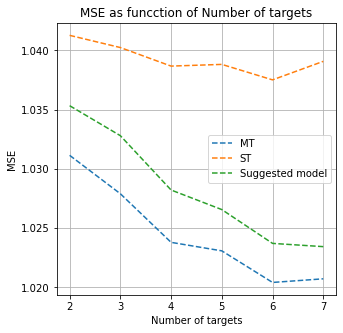

<Figure size 432x432 with 0 Axes>

--- 353482.44966077805 seconds ---


In [15]:
plot_dependencies(range(2, N_TARGETS+1), mse_for_all, mse_for_individual, mse_LOO, 'Number of targets')
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
start_time = time.time()
print(f'Cell execution time: {datetime.datetime.now()}')
mse_for_all_ra, mse_for_individual_ra, mse_LOO_ra = mse_depnding_on_correlation(n_targets=N_TARGETS,random_alpha=True,
                                                                       n_samples=6`00,use_pruning=True, n_iter=500,
                                                                       sd=1)


Cell execution time: 2023-05-25 16:49:58.516726


n Progress Bar:  17%|█▋        | 1/6 [3:41:47<18:28:55, 13307.05s/it]

mse_for_all_mean=[1.140521159006108]
mse_for_individual_mean=[1.0869077522334696]
mse_Loo_mean=[1.0843370153872507]


n Progress Bar:  33%|███▎      | 2/6 [8:53:35<18:18:58, 16484.53s/it]

mse_for_all_mean=[1.140521159006108, 1.1666613982884642]
mse_for_individual_mean=[1.0869077522334696, 1.0866583262241112]
mse_Loo_mean=[1.0843370153872507, 1.0810882369745918]


n Progress Bar:  50%|█████     | 3/6 [15:38:43<16:42:50, 20056.86s/it]

mse_for_all_mean=[1.140521159006108, 1.1666613982884642, 1.1890993388783981]
mse_for_individual_mean=[1.0869077522334696, 1.0866583262241112, 1.0861526311544936]
mse_Loo_mean=[1.0843370153872507, 1.0810882369745918, 1.080966500695697]


n Progress Bar:  67%|██████▋   | 4/6 [23:58:12<13:18:59, 23969.80s/it]

mse_for_all_mean=[1.140521159006108, 1.1666613982884642, 1.1890993388783981, 1.1991688334511796]
mse_for_individual_mean=[1.0869077522334696, 1.0866583262241112, 1.0861526311544936, 1.0830868500248516]
mse_Loo_mean=[1.0843370153872507, 1.0810882369745918, 1.080966500695697, 1.077971544029259]


n Progress Bar:  83%|████████▎ | 5/6 [33:51:07<7:49:15, 28155.01s/it] 

mse_for_all_mean=[1.140521159006108, 1.1666613982884642, 1.1890993388783981, 1.1991688334511796, 1.207042821966672]
mse_for_individual_mean=[1.0869077522334696, 1.0866583262241112, 1.0861526311544936, 1.0830868500248516, 1.0795046528715753]
mse_Loo_mean=[1.0843370153872507, 1.0810882369745918, 1.080966500695697, 1.077971544029259, 1.0739118075855498]


n Progress Bar: 100%|██████████| 6/6 [45:17:52<00:00, 27178.76s/it]  

mse_for_all_mean=[1.140521159006108, 1.1666613982884642, 1.1890993388783981, 1.1991688334511796, 1.207042821966672, 1.220441987527623]
mse_for_individual_mean=[1.0869077522334696, 1.0866583262241112, 1.0861526311544936, 1.0830868500248516, 1.0795046528715753, 1.0786675269598291]
mse_Loo_mean=[1.0843370153872507, 1.0810882369745918, 1.080966500695697, 1.077971544029259, 1.0739118075855498, 1.0735767040428605]


In [17]:
mse_for_all_ra, mse_for_individual_ra, mse_LOO_ra

([1.140521159006108,
  1.1666613982884642,
  1.1890993388783981,
  1.1991688334511796,
  1.207042821966672,
  1.220441987527623],
 [1.0869077522334696,
  1.0866583262241112,
  1.0861526311544936,
  1.0830868500248516,
  1.0795046528715753,
  1.0786675269598291],
 [1.0843370153872507,
  1.0810882369745918,
  1.080966500695697,
  1.077971544029259,
  1.0739118075855498,
  1.0735767040428605])

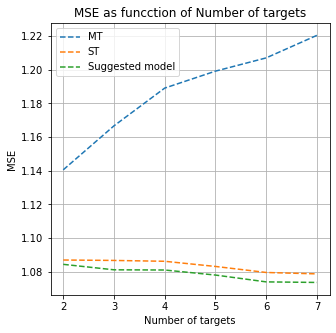

<Figure size 432x432 with 0 Axes>

--- 190063.41204881668 seconds ---


In [20]:
plot_dependencies(range(2, N_TARGETS+1), mse_for_all_ra, mse_for_individual_ra, mse_LOO_ra, 'Number of targets')
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))